In [1]:
import sisl
from hubbard import HubbardHamiltonian, sp2, density, plot
%matplotlib inline

# Isolated structures (molecules)

In this example we study the effect of on-site Coulomb interactions for electrons in a carbon-based molecular geometry by solving the mean-field Hubbard equation

We will start by building the geometry and the TB Hamiltonian for an sp2 carbon-based structure using `sisl`. The geometry will be read with `sisl` from this [file](https://github.com/dipc-cc/hubbard/blob/master/examples/molecules/clar-goblet/clar-goblet.xyz).

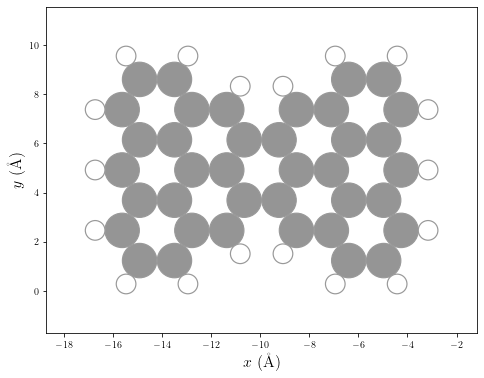

In [2]:
# Build sisl.Geometry object
geom = sisl.get_sile('../../examples/molecules/clar-goblet/clar-goblet.xyz').read_geometry()

# Plot geometry: Carbon atoms in gray, Hydrogen atoms in white
p = plot.GeometryPlot(geom, cmap='Greys')
# This is just to plot Hydrogen atoms in white
p.paux.set_clim(0, 0)

To build the TB Hamiltonian (which describes the kinetic part of the system's Hamiltonian) one can use the function from the `hubbard` package `sp2` that builds the TB `sisl.Hamiltonian` of an sp2 carbon system. In this example we will use the first nearest neighbors interactions (1NN) TB model, typically used to simulate graphene-based nanostructures.

In [3]:
# Build sisl.Hamiltonian object using the sp2 function
H0 = sp2(geom, t1=2.7, t2=0., t3=0., spin='polarized')

The second step is to build the `HubbardHamiltonian` object, which will enable the routines to iterate the mean field Hubbard Hamiltonian until it finds the self-consistent solution (convergence). To model the interaction part (Hubbard term) we will use `U=3.5` eV.  See for instance [Nature Communications 10, 200 (2019)](https://www.nature.com/articles/s41467-018-08060-6) for reference.

In [4]:
# Build the HubbardHamiltonian object with U=3.5.
# One can set the total number of up/down spin electrons by passing q=(q_up, q_dn). In this case, since there
# is an even total number of electrons we can start with q=(ntot/2, ntot/2).
HH = HubbardHamiltonian(H0, q=(len(H0)/2, len(H0)/2), U=3.5, kT=0.025)

##### Important note before starting the convergence process
It is important to give an initial spin-density that breaks the symmetry between the up- and down- spin channels to start the convergence of the `HubbardHamiltonian` object. Otherwise the code *will not be able to find a solution*.
Furthermore, the closer the initial spin-densities are to the self-consistent solution, the faster the code will find it.

In [5]:
HH.set_polarization([2,6,10], dn=[24,28,32])

Now we can start the convergence until we find the self-consistent solution up to a desired tolerance (`tol`) by calling the `HubbardHamiltonian.converge` method. This method needs as a mandatory argument another function that returns the spin-densities, since depending on the system or the boundary conditions the spin-densities will be obtain differently. For instance, to compute the spin-densities for TB Hamiltonians with *finite or periodic* boundary conditions, one can use the method `hubbard.density.calc_n`.

In [6]:
# Converge until a tolerance of tol=1e-10
dn = HH.converge(density.calc_n, tol=1e-10, print_info=True, steps=1)

   HubbardHamiltonian: converge towards tol=1.00e-10
   1 iterations completed: 0.5000000000000189 -179.259792397134
   2 iterations completed: 0.06187870540897589 -246.48339932965422
   3 iterations completed: 0.03262766358907587 -246.46128463327622
   4 iterations completed: 0.005577074762743162 -246.54288102974022
   5 iterations completed: 0.001590695329941716 -246.58392834159875
   6 iterations completed: 0.0003939518266086184 -246.60028150400262
   7 iterations completed: 3.853298342204603e-05 -246.59823272972324
   8 iterations completed: 1.2569131205786288e-05 -246.5983134009241
   9 iterations completed: 2.066709302139813e-06 -246.59817956357304
   10 iterations completed: 7.121974041623957e-07 -246.5982066363112
   11 iterations completed: 9.207019807666583e-08 -246.59819647159546
   12 iterations completed: 3.800878933812868e-08 -246.59819631460275
   13 iterations completed: 6.7612268006556064e-09 -246.5981962066005
   14 iterations completed: 5.77773884291588e-10 -246.5981

##### Understanding the final results
Now one can visualize some meaningful physical quantities and properties of the solution, e.g. such as the spin polarization. Other interesting electronic properties can be visualized using the `hubbard.plot` module.


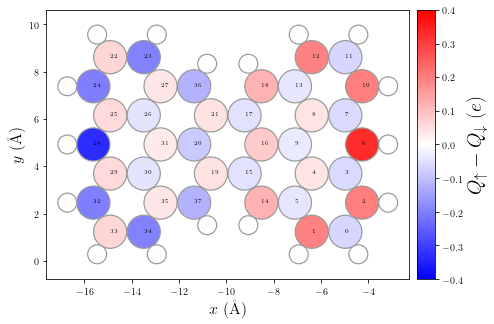

In [7]:
# Let's visualize some relevant physical quantities of the final result (this process may take a few seconds)
# By passing the argument ext_geom one can plot the spin polarization using the full geometry for the sp2 system
# e.g. including Hydrogen atoms. Otherwise it only displays the pi-network structure
p = plot.SpinPolarization(HH, colorbar=True, vmax=0.4, vmin=-0.4, ext_geom=geom)
p.annotate()

In [8]:
# Print total energy
print(f"Total energy = {HH.Etot}")

Total energy = -246.59819622643164


##### Using output of the mean-field Hubbard model to start SIESTA calculation
The `hubbard` package can be used to give a starting spin-density distribution for a more accurate spin polarized SIESTA calculation, by writing the spin densities to a `fdf-block`:

In [9]:
# Write the self-consistent solution of the mean-field Hubbard calculation
# to an input file for a SIESTA calculation.
# ext_geom is the full sp2 geometry,  e.g. that includes the Hydrogen atoms.
# Otherwise it uses only the pi-network backbone structure stored in the H0 Hamiltonian
HH.write_initspin('init-spin.fdf', ext_geom=geom)